### This is where the model is trained.

For the POC level the following will not be addressed:
1. Hyperparameter tuning
2. kNN pre-imputer
3. Modifications and advancements to the model
4. Use of temporal data

In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the dataset
file_path = 'data/dat.csv'  # Replace with actual path if different
ehr_data = pd.read_csv(file_path)

In [3]:
# drop rows with >50% missing values
cleaned_data = ehr_data.select_dtypes(include=['number']).dropna(thresh=ehr_data.shape[1] * 0.5)

# Fill missing values with column means
cleaned_data.fillna(cleaned_data.mean(), inplace=True)

# Remove duplicates, completely empty and unnecessary columns
cleaned_data = cleaned_data.drop_duplicates().dropna(axis=1, how='all')
cleaned_data = cleaned_data.loc[:, cleaned_data.columns != 'Unnamed: 0']

# Display the cleaned data head for verification
print("Cleaned Data Sample:")
print(cleaned_data.head())

Cleaned Data Sample:
   inpatient.number  visit.times  body.temperature  pulse  respiration  \
0            857781            1              36.7     87           19   
1            743087            1              36.8     95           18   
2            866418            2              36.5     98           18   
3            775928            1              36.0     73           19   
4            810128            1              35.0     88           19   

   systolic.blood.pressure  diastolic.blood.pressure        map  weight  \
0                      102                        64  76.666667    50.0   
1                      150                        70  96.666667    51.0   
2                      102                        67  78.666667    70.0   
3                      110                        74  86.000000    65.0   
4                      134                        62  86.000000    76.0   

   height  ...  carboxyhemoglobin  body.temperature.blood.gas  \
0    1.64  ...    

# Converting data to a tensor

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ehr_tensor = torch.tensor(cleaned_data.values, dtype=torch.float32).to(device)

print(f"EHR tensor shape: {ehr_tensor.shape}")

EHR tensor shape: torch.Size([1987, 150])


# Normalizing the data

In [5]:
scaler = MinMaxScaler()

normalized_data = scaler.fit_transform(cleaned_data)
ehr_tensor_normalized = torch.tensor(normalized_data, dtype=torch.float32).to(device)

print(f"Normalized EHR tensor shape: {ehr_tensor_normalized.shape}")
print("Sample of the normalized tensor:")
print(ehr_tensor_normalized[:5])

Normalized EHR tensor shape: torch.Size([1987, 150])
Sample of the normalized tensor:
tensor([[7.3888e-01, 0.0000e+00, 2.4286e-01, 4.3939e-01, 5.2778e-01, 4.0476e-01,
         4.3836e-01, 4.2279e-01, 4.3478e-01, 8.7162e-01, 4.6006e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3333e-01, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.5190e-01, 0.0000e+00, 5.9251e-01, 6.0214e-01, 1.1854e-02,
         9.9399e-03, 5.8072e-02, 4.3021e-01, 4.0107e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.3095e-02, 5.5133e-02,
         0.0000e+00, 5.5143e-02, 8.6236e-02, 2.4904e-01, 4.6251e-01, 1.9951e-01,
         1.0750e-01, 2.4960e-01, 3.0970e-01, 3.4052e-01, 5.2202e-01, 1.7680e-01,
         2.7397e-01, 4.7051e-01, 5.7339e-01, 2.1634e-01, 5.5219e-01, 7.7477e-01,
         6.3636e-01, 9.

# Creating train-validation-test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_data, temp_data = train_test_split(ehr_tensor_normalized, test_size=0.2, random_state=42) # 20% temporary
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42) # 20% temp divided 50/50 for validation and test

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: torch.Size([1589, 150])
Validation data shape: torch.Size([199, 150])
Test data shape: torch.Size([199, 150])


# Training the model

### Hyperparameters

In [8]:
input_dim = ehr_tensor_normalized.shape[1]  # Number of features (dataset)
d_model = 128                               # Size of the embedding
nhead = 8                                   # Number of attention heads
num_encoder_layers = 4                      # Number of encoder layers
dim_feedforward = 256                       # Size of the feedforward network
dropout = 0.1                               # Dropout rate

### Model initiation

In [9]:
from ehr_imputation_transformer import EHRImputationTransformer as tr_model

model = tr_model(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout).to(device)

print(model) # Model summary

EHRImputationTransformer(
  (input_embedding): Linear(in_features=150, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=150, bias=True)
)


### Optimizer and loss function

In [10]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error Loss for continuous data

### Training loop setup

In [11]:
def train_model(model, train_data, val_data, num_epochs):
    
    model.train()

    train_data = train_data.unsqueeze(1) 
    val_data = val_data.unsqueeze(1)

    for epoch in range(num_epochs):

        optimizer.zero_grad()

        # Forward pass
        outputs = model(train_data)

        loss = criterion(outputs, train_data)

        loss.backward()
        optimizer.step()

        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        # Validation step
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(val_data)
                val_loss = criterion(val_outputs, val_data)
            print(f'Validation Loss after epoch {epoch + 1}: {val_loss.item():.4f}')
            model.train()

In [12]:
train_model(model, train_data, val_data, num_epochs=50)

c:\Users\emith\anaconda3\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [10/50], Loss: 0.0461
Validation Loss after epoch 10: 0.0332
Epoch [20/50], Loss: 0.0353
Validation Loss after epoch 20: 0.0219
Epoch [30/50], Loss: 0.0316
Validation Loss after epoch 30: 0.0199
Epoch [40/50], Loss: 0.0284
Validation Loss after epoch 40: 0.0184
Epoch [50/50], Loss: 0.0268
Validation Loss after epoch 50: 0.0180


In [13]:
model.eval()

EHRImputationTransformer(
  (input_embedding): Linear(in_features=150, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=150, bias=True)
)

In [14]:
# Ensure validation and test data have the correct shape before forward pass
if len(val_data.shape) == 2:
    val_data = val_data.unsqueeze(1)  # Add a sequence length dimension (shape: [batch_size, 1, num_features])
if len(test_data.shape) == 2:
    test_data = test_data.unsqueeze(1)  # Add a sequence length dimension (shape: [batch_size, 1, num_features])

# Forward pass for validation and test data
with torch.no_grad():
    val_outputs = model(val_data)
    test_outputs = model(test_data)

In [15]:
def calculate_rmse(predicted, actual):
    return np.sqrt(((predicted - actual) ** 2).mean())

val_outputs_np = val_outputs.cpu().numpy()
val_data_np = val_data.cpu().numpy()

test_outputs_np = test_outputs.cpu().numpy()
test_data_np = test_data.unsqueeze(0).cpu().numpy()

# Calculate RMSE
val_rmse = calculate_rmse(val_outputs_np, val_data_np)
test_rmse = calculate_rmse(test_outputs_np, test_data_np)

In [16]:
print(f'Validation RMSE: {val_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Validation RMSE: 0.1341
Test RMSE: 0.1286


# Creating data with synthetic missingness

In [17]:
import numpy as np
import matplotlib.pyplot as plt

missingness_prob = 0.1  # Set 10% of data to be missing
test_data_with_missing = test_data.clone()

mask = torch.rand(test_data_with_missing.shape).to(device) < missingness_prob
test_data_with_missing[mask] = float('nan')

input_for_model = test_data_with_missing.clone()
input_for_model[mask] = 0

### Imputing data

In [18]:
with torch.no_grad():
    imputed_data = model(input_for_model)

In [19]:
imputed_data

tensor([[[0.4392, 0.0235, 0.2129,  ..., 0.5426, 0.9985, 0.0818]],

        [[0.4361, 0.0200, 0.2080,  ..., 0.5389, 0.9956, 0.0755]],

        [[0.4478, 0.0194, 0.2118,  ..., 0.5507, 1.0033, 0.0871]],

        ...,

        [[0.4439, 0.0295, 0.2119,  ..., 0.5375, 1.0012, 0.0877]],

        [[0.4471, 0.0293, 0.2101,  ..., 0.5469, 1.0060, 0.0788]],

        [[0.4478, 0.0238, 0.2116,  ..., 0.5447, 0.9954, 0.0857]]],
       device='cuda:0')

In [20]:
imputed_data = imputed_data.cpu().numpy()
test_data_np = test_data.cpu().numpy()  # Original test data for comparison
imputed_data[~mask.cpu().numpy()] = test_data_np[~mask.cpu().numpy()]  # Replace non-missing values with original data

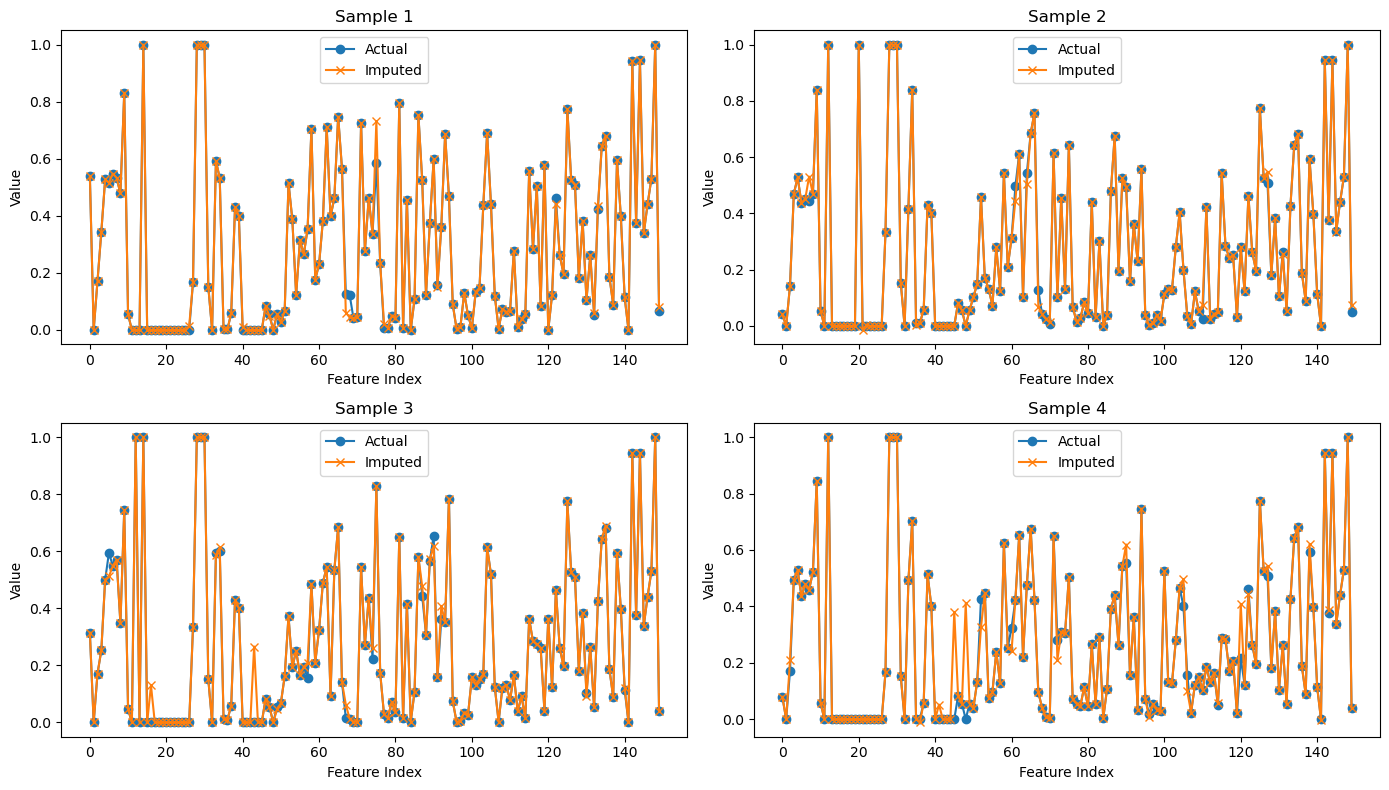

In [21]:
# Ensure num_samples_to_plot is within the range for creating subplots
num_samples_to_plot = 4  # Adjust this value based on your layout

# Visualize actual vs. imputed values for a few samples (features)
plt.figure(figsize=(14, 8))
for i in range(num_samples_to_plot):  # Adjust to ensure we don't exceed available subplots
    plt.subplot(2, (num_samples_to_plot + 1) // 2, i + 1)  # Create subplots dynamically
    plt.plot(test_data_np[i, 0, :], label='Actual', marker='o')  # Plot all features for sample i
    plt.plot(imputed_data[i, 0, :], label='Imputed', marker='x')  # Plot all features for sample i
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [22]:
def calculate_rmse_for_imputed(imputed, actual, mask):
    imputed = imputed[mask]  # Use only the imputed values for positions that were missing
    actual = actual[mask]  # Use the actual values for positions that were missing
    return np.sqrt(((imputed - actual) ** 2).mean())

# Convert imputed and original test data to numpy arrays for RMSE calculation
imputed_data_np = imputed_data
test_data_np = test_data.cpu().numpy()
mask_np = mask.cpu().numpy()  # Mask indicating positions with missing values

# Calculate RMSE for the imputed values on MCAR data
rmse_imputed = calculate_rmse_for_imputed(imputed_data_np, test_data_np, mask_np)
print(f'RMSE for Imputed Values on MCAR Data: {rmse_imputed:.4f}')

RMSE for Imputed Values on MCAR Data: 0.1213


In [23]:
# Normalize RMSE using the range (max - min) of the actual data
data_range = np.max(test_data_np) - np.min(test_data_np)
nrmse_imputed = rmse_imputed / data_range  # Alternatively, use mean: rmse_imputed / np.mean(test_data_np)

print(f'RMSE for Imputed Values on MCAR Data: {rmse_imputed:.4f}')
print(f'NRMSE for Imputed Values on MCAR Data: {nrmse_imputed:.4f}')

RMSE for Imputed Values on MCAR Data: 0.1213
NRMSE for Imputed Values on MCAR Data: 0.1213
